# Klasifikasi Penyakit Tanaman Anggur Menggunakan MobileNet V3 Small

## Anggota Kelompok
- Ahmad Taufiq Nur Rohman  
- Nugroho Rahmanto  

## Latar Belakang  
Dalam era modern, layanan **cloud computing** telah menjadi salah satu solusi utama dalam pengembangan dan pelatihan model kecerdasan buatan. Dengan adanya layanan cloud, proses pelatihan deep learning dapat dilakukan secara lebih efisien tanpa terbatas oleh keterbatasan perangkat keras lokal.  

Tugas ini bertujuan untuk memberikan pengalaman langsung dalam memanfaatkan layanan **Google Colab** dengan **GPU T4** untuk melatih model deep learning. Kami menggunakan **MobileNet V3 Small**, yang merupakan model ringan dan efisien, dengan studi kasus klasifikasi gambar penyakit pada daun tanaman anggur. Pemilihan studi kasus ini dilakukan sebagai contoh penerapan model deep learning untuk tugas klasifikasi yang relatif sederhana, sehingga mahasiswa dapat memahami proses pelatihan dan implementasi model dalam skala kecil.  

Selain melatih model, kami juga mengembangkan antarmuka berbasis web agar hasil model dapat diakses dengan lebih mudah. Frontend dikembangkan menggunakan **Laravel**, sementara backend menggunakan **Python dengan Flask**. Proyek ini dihosting di **VPS dengan layanan Domainesia**, memberikan pengalaman langsung dalam mengintegrasikan deep learning dengan deployment berbasis cloud.

## Langkah-Langkah dalam Tugas Ini  
1. **Persiapan Data** – Melakukan pre-processing dataset agar siap digunakan dalam pelatihan model.  
2. **Pemilihan Model** – Menggunakan **MobileNet V3 Small** karena efisien untuk tugas klasifikasi gambar.  
3. **Training Model** – Melatih model menggunakan dataset yang tersedia dengan berbagai teknik optimasi.  
4. **Evaluasi Model** – Menganalisis performa model menggunakan metrik evaluasi seperti **akurasi dan loss**.  
5. **Pembuatan UI Website** – Mengembangkan antarmuka berbasis web untuk menguji dan mengakses model secara langsung.  

Melalui tugas ini, mahasiswa dapat memahami seluruh proses **pengembangan model deep learning berbasis cloud**, mulai dari **persiapan data, pelatihan model, evaluasi, hingga deployment**. Pengalaman ini diharapkan dapat menjadi dasar bagi proyek-proyek deep learning selanjutnya yang lebih kompleks.

<hr>
<hr>



In [1]:
# Import module yang dibutuhkan
import os
import zipfile
import gdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import resample

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, AveragePooling2D, Flatten
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print('Modules loaded')

Modules loaded


In [2]:
# Cek apakah GPU sudah terinstall dan dapat digunakan
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<hr>
<hr>

## 1. Persiapan Data dan Preprocessing  

### 1.1 Sumber Dataset  
Dataset yang digunakan dalam tugas ini berasal dari dataset **PlantVillage**, yang berisi berbagai gambar daun tanaman dengan berbagai kondisi kesehatan. Dataset ini tersedia dalam Google Drive dalam bentuk folder **Train** dan **Test**, yang masing-masing berisi gambar untuk pelatihan dan pengujian model. Dataset dapat diakses melalui tautan berikut: **[Dataset Google Drive](https://drive.google.com/file/d/1BvVDMzJZQsK8ORrMwl9pob1e5yUKzOwY/view?usp=drive_link)**.

Setelah diekstrak, dataset terdiri dari:

| Kategori  | Background | Grape Black Rot | Grape Esca | Grape Healthy | Grape Leaf Blight | Total |
|-----------|------------|----------------|------------|---------------|-------------------|-------|
| **Train Set** | 914 | 944 | 1,106 | 338 | 860 | 4,162 |
| **Test Set** | 229 | 236 | 277 | 85 | 216 | 1,043 |

### 1.2 Preprocessing Data  

Agar dataset siap digunakan dalam pelatihan model deep learning, dilakukan beberapa langkah preprocessing sebagai berikut:

1. **Split Dataset**  
   - Dataset **Train** dibagi menjadi dua bagian: **Training Set (80%)** dan **Validation Set (20%)** menggunakan metode `train_test_split`.
   - Test set tetap dipertahankan secara terpisah untuk evaluasi akhir model.

2. **Oversampling pada Data Train**  
   - Karena dataset memiliki distribusi kelas yang tidak seimbang, diterapkan teknik **oversampling** pada dataset **Training** agar jumlah sampel tiap kelas lebih seimbang.
   - Oversampling dilakukan dengan metode **resampling** gambar dari kelas minoritas hingga jumlahnya menyesuaikan kelas mayoritas.

3. **Normalisasi dan Augmentasi Data**  
   - Setiap gambar dinormalisasi menggunakan fungsi `preprocess_input()` agar sesuai dengan format input MobileNet V3.
   - Augmentasi gambar diterapkan untuk meningkatkan variasi data dengan teknik berikut:
     - **Rotasi** (rotation_range=5°)  
     - **Zoom** (zoom_range=0.1)  
     - **Flip Horizontal**  

4. **Pembuatan Data Generator**  
   - Menggunakan **ImageDataGenerator** untuk membuat batch data secara otomatis selama pelatihan model.
   - Tiga generator data dibuat, yaitu:
     - **train_gen** untuk data latih
     - **valid_gen** untuk data validasi
     - **test_gen** untuk data uji

### 1.3 Distribusi Dataset Akhir  

Setelah preprocessing, berikut adalah distribusi dataset:

| Kelas                 | Training | Validation | Testing |
|-----------------------|---------|-----------|---------|
| Grape Leaf Blight     | 872     | 192       | 216     |
| Grape Esca           | 872     | 219       | 277     |
| Background           | 872     | 198       | 229     |
| Grape Healthy        | 872     | 58        | 85      |
| Grape Black Rot      | 872     | 166       | 236     |
| **Total**            | **4360** | **833**   | **1043**|

Dengan langkah-langkah ini, dataset telah siap untuk digunakan dalam pelatihan model deep learning berbasis cloud.

<hr>
<hr>

In [3]:
gdrive_file_id = '1BvVDMzJZQsK8ORrMwl9pob1e5yUKzOwY'  # Ganti dengan ID Google Drive dataset Anda
zip_path = 'GrapePlantVillage.zip'  # Path untuk menyimpan file zip

gdown.download(f'https://drive.google.com/uc?id={gdrive_file_id}', zip_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1BvVDMzJZQsK8ORrMwl9pob1e5yUKzOwY
From (redirected): https://drive.google.com/uc?id=1BvVDMzJZQsK8ORrMwl9pob1e5yUKzOwY&confirm=t&uuid=14996a42-7772-45b8-8051-64055611e5cb
To: /content/GrapePlantVillage.zip
100%|██████████| 83.6M/83.6M [00:00<00:00, 119MB/s]


'GrapePlantVillage.zip'

In [4]:
data_path = 'GrapePlantVillage'  # Path tempat ekstraksi
dataset_train_path = os.path.join(data_path, 'train')  # Folder train
dataset_test_path = os.path.join(data_path, 'test')  # Folder test

# Mengekstrak file ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_path)

In [5]:
def generate_data_paths(data_path):
    filepaths = []
    labels = []

    folds = os.listdir(data_path)
    for fold in folds:
        foldpath = os.path.join(data_path, fold)
        if os.path.isdir(foldpath):
            filelist = os.listdir(foldpath)
            for file in filelist:
                fpath = os.path.join(foldpath, file)
                filepaths.append(fpath)
                labels.append(fold)

    return filepaths, labels

train_filepaths, train_labels = generate_data_paths(dataset_train_path)
test_filepaths, test_labels = generate_data_paths(dataset_test_path)

def create_df(filepaths, labels):
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)
    return df

# Membuat dataframe untuk train dan test
df_train = create_df(train_filepaths, train_labels)
df_test = create_df(test_filepaths, test_labels)

In [6]:
def num_of_examples(df, name='df'):
    print(f"The {name} dataset has {df.shape[0]} images.")

num_of_examples(df_train, "train")
num_of_examples(df_test, "test")

The train dataset has 4162 images.
The test dataset has 1043 images.


In [7]:
# split pada train dataframe untuk train dan val
df_train, df_validation = train_test_split(df_train,  train_size= 0.8, shuffle=True, random_state= 42)

In [9]:
def classes_count(df, name='df'):
    total_images = len(df)
    print(f"The {name} dataset has: {total_images} images")
    print("="*70)
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"Class '{name}' has {num_class} images")
        print('-'*70)

classes_count(df_train, 'training')

The training dataset has: 3329 images
Class 'Grape_Leaf blight' has 668 images
----------------------------------------------------------------------
Class 'Background' has 749 images
----------------------------------------------------------------------
Class 'Grape_Esca' has 872 images
----------------------------------------------------------------------
Class 'Grape_healthy' has 283 images
----------------------------------------------------------------------
Class 'Grape_Black rot' has 757 images
----------------------------------------------------------------------


In [11]:
def num_imgs(df, name='df'):
    print(f"Number of {name} dataset is {len(df)} images")

num_imgs(df_train, 'Training')
num_imgs(df_validation, 'Validation')
num_imgs(df_test, 'Testing')

Number of Training dataset is 3329 images
Number of Validation dataset is 833 images
Number of Testing dataset is 1043 images


In [12]:
# Oversampling data train. Sehingga jumlah kelas minoritas menyesuaikan dengan jumlah kelas mayoritas

def oversample_dataframe(df, target_column, random_state=42):
    max_samples = df[target_column].value_counts().max()
    df_list = []
    for label in df[target_column].unique():
        df_class = df[df[target_column] == label]
        if len(df_class) < max_samples:  # Hanya oversample kelas minoritas
            df_class = resample(df_class,
                                replace=True,
                                n_samples=max_samples,
                                random_state=random_state)
        df_list.append(df_class)
    return pd.concat(df_list)

df_train = oversample_dataframe(df_train, 'labels')

In [13]:
classes_count(df_train, 'training')
print()
classes_count(df_validation, 'validation')
print()
classes_count(df_test, 'test')

The training dataset has: 4360 images
Class 'Grape_Leaf blight' has 872 images
----------------------------------------------------------------------
Class 'Background' has 872 images
----------------------------------------------------------------------
Class 'Grape_Esca' has 872 images
----------------------------------------------------------------------
Class 'Grape_healthy' has 872 images
----------------------------------------------------------------------
Class 'Grape_Black rot' has 872 images
----------------------------------------------------------------------

The validation dataset has: 833 images
Class 'Background' has 165 images
----------------------------------------------------------------------
Class 'Grape_Black rot' has 187 images
----------------------------------------------------------------------
Class 'Grape_Leaf blight' has 192 images
----------------------------------------------------------------------
Class 'Grape_Esca' has 234 images
---------------------

#### Data Generator

In [16]:
# Membuat data generator untuk tahap training model

batch_size = 32
img_size = (224, 224)

def scalar(img):
    img = preprocess_input(img)
    return img

tr_gen = ImageDataGenerator(preprocessing_function=scalar,
                            rotation_range=10,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            vertical_flip=False
                            )
ts_gen = ImageDataGenerator(preprocessing_function=scalar)

train_gen = tr_gen.flow_from_dataframe(df_train,
                                       x_col='filepaths',
                                       y_col='labels',
                                       target_size=img_size,
                                       class_mode='categorical',
                                       color_mode='rgb',
                                       shuffle=True,
                                       batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(df_validation,
                                       x_col='filepaths',
                                       y_col='labels',
                                       target_size=img_size,
                                       class_mode='categorical',
                                       color_mode='rgb',
                                       shuffle=False,
                                       batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(df_test,
                                      x_col='filepaths',
                                      y_col='labels',
                                      target_size=img_size,
                                      class_mode='categorical',
                                      color_mode='rgb',
                                      shuffle=False,
                                      batch_size=batch_size)

class_mapping = train_gen.class_indices

# Menampilkan mapping indeks -> nama kelas
print("\nIndex to class name:")
for class_name, index in class_mapping.items():
    print(f"{index} -> {class_name}")

Found 4360 validated image filenames belonging to 5 classes.
Found 833 validated image filenames belonging to 5 classes.
Found 1043 validated image filenames belonging to 5 classes.

Index to class name:
0 -> Background
1 -> Grape_Black rot
2 -> Grape_Esca
3 -> Grape_Leaf blight
4 -> Grape_healthy


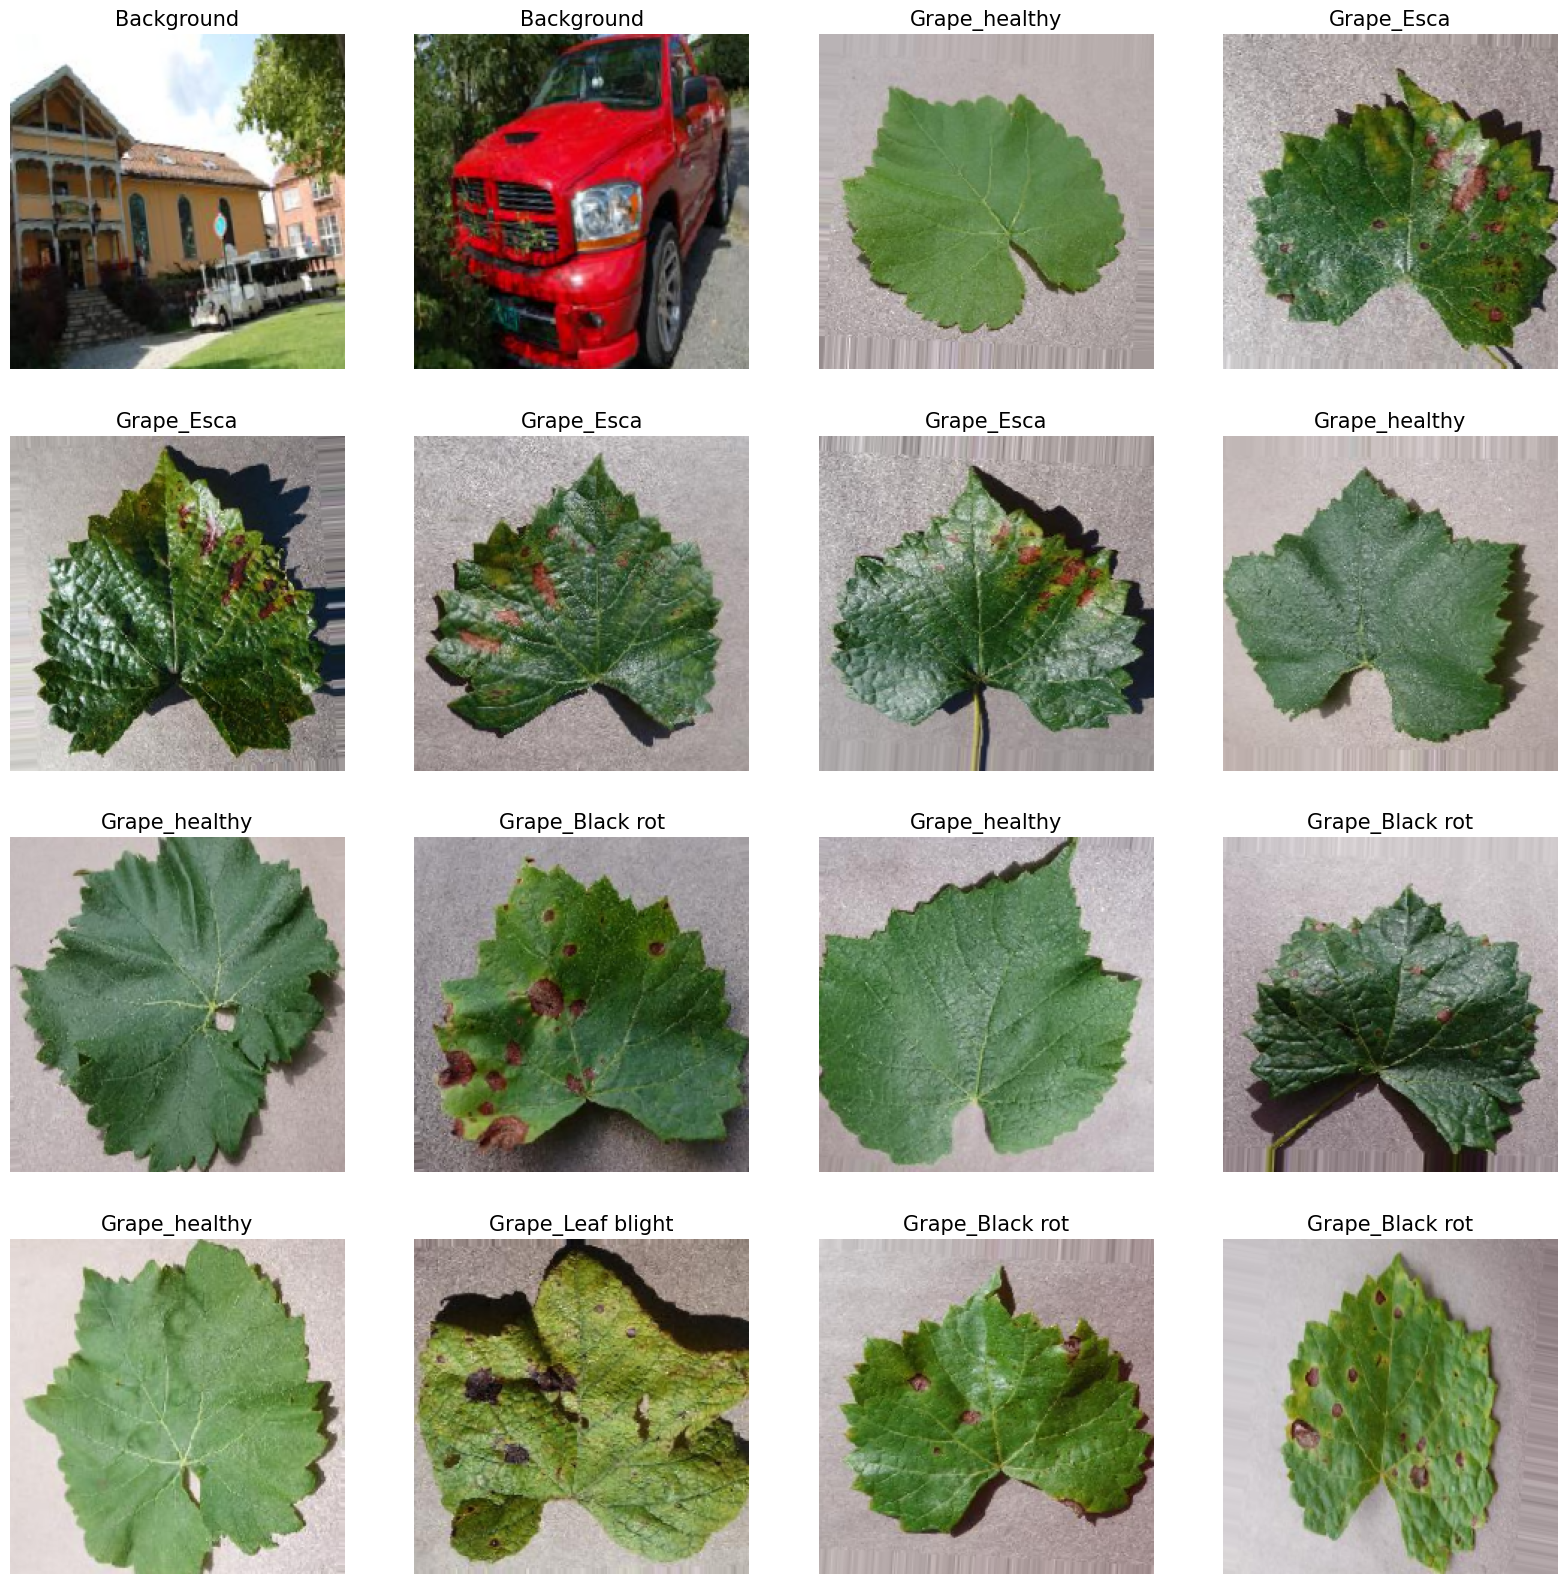

In [17]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (20, 20))

for i in range(16):

    plt.subplot(4, 4, i + 1)
    image = images[i] / 255.0
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'black', fontsize= 15)
    plt.axis('off')

plt.show()

## 2. Pemilihan Model

### 2.1 Arsitektur Model
Pada tahap ini, digunakan arsitektur **MobileNetV3-Small** sebagai _base model_ untuk klasifikasi gambar daun anggur. MobileNetV3 merupakan model _deep learning_ yang ringan dan dioptimalkan untuk perangkat dengan keterbatasan daya komputasi. Model ini telah dilatih sebelumnya dengan dataset **ImageNet**, sehingga dapat dimanfaatkan sebagai fitur ekstraktor dalam proses transfer learning.

#### **Struktur Model yang Digunakan**

- **MobileNetV3-Small** digunakan sebagai _feature extractor_.
- Lapisan tambahan ditambahkan setelah base model:
  - **Dense(1028, activation='relu')** → Lapisan _fully connected_ pertama untuk menangkap pola kompleks.
  - **AveragePooling2D(pool_size=(2,2))** → Mengurangi dimensi fitur untuk mencegah overfitting.
  - **Dense(514, activation='relu')** → Lapisan tambahan untuk pemrosesan fitur lebih lanjut.
  - **Flatten()** → Mengubah output menjadi format vektor satu dimensi.
  - **Dense(class_count, activation='softmax')** → Lapisan output untuk klasifikasi multi-kelas.

### 2.2 Kompilasi Model

**Detail kompilasi model:**
- **Optimizer:** Adam dengan learning rate `1e-5`, dipilih untuk stabilitas dalam _fine-tuning_.
- **Loss Function:** `categorical_crossentropy`, digunakan karena ini merupakan klasifikasi multi-kelas.
- **Metrics:**
  - `accuracy` untuk mengevaluasi persentase prediksi yang benar.
  - `f1_score` untuk menilai keseimbangan antara presisi dan recall.

### 2.3 Ringkasan Model
Model yang telah dibuat dapat dilihat menggunakan perintah berikut:

```python
model.summary()
```

Perintah ini akan menampilkan jumlah parameter, jumlah layer, serta struktur detail dari model yang telah dibuat.

Dengan pemilihan model ini, diharapkan performa klasifikasi gambar daun anggur dapat dioptimalkan secara efisien menggunakan MobileNetV3-Small sebagai dasar transfer learning.

<hr>
<hr>

In [18]:
# Create Model Structure
input_tensor = Input(shape=(224, 224, 3))
class_count = len(list(train_gen.class_indices.keys()))

base_model = MobileNetV3Small(
    weights='imagenet',
    include_top=False,
    pooling=None,
    input_tensor = input_tensor
)

x = base_model.output

x = Dense(1028, activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = Dense(514, activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = Flatten()(x)

x = Dense(class_count, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [19]:
optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', 'f1_score'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 112, 112, 16)   │            432 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 112, 112, 16)   │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 16)   │              0 │ conv_bn[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 113, 113, 16)   │              0 │ activation[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 56, 56, 16)     │            144 │ expanded_conv_depthwi… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 56, 56, 16)     │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 56, 56, 16)     │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │              0 │ re_lu[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │            136 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │              0 │ expanded_conv_squeeze… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │            144 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 1, 16)       │              0 │ expanded_conv_squeeze… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 1, 1, 16)       │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)  

 Total params: 2,063,757 (7.87 MB)

 Trainable params: 2,051,645 (7.83 MB)

 Non-trainable params: 12,112 (47.31 KB)

## 3. Training Model  

Setelah pemilihan model selesai, langkah berikutnya adalah melakukan **training** model menggunakan dataset yang telah diproses sebelumnya.

### 3.1 Hyperparameter yang Digunakan
Beberapa hyperparameter yang digunakan dalam proses training adalah sebagai berikut:

- **Epochs = 25** → Model akan dilatih selama 25 iterasi penuh terhadap dataset training.
- **Batch Size 32** → Jumlah sampel yang digunakan dalam satu iterasi training, ditentukan dalam data generator.
- **Optimizer = Adam** → Digunakan **Adam Optimizer** dengan learning rate `1e-5` untuk melakukan pembaruan bobot secara adaptif.
- **Loss Function = Categorical Crossentropy** → Fungsi loss yang digunakan untuk klasifikasi multi-kelas.
- **Metrics = Accuracy & F1 Score** → Evaluasi model menggunakan **akurasi** dan **F1-score** untuk mengukur keseimbangan antara precision dan recall.

### 3.2 Validasi Model
Dataset validasi digunakan untuk mengevaluasi performa model setelah setiap epoch. Hasil validasi ini membantu dalam mendeteksi **overfitting** atau **underfitting**, serta memastikan model memiliki generalisasi yang baik pada data baru.

### 3.3 Output Training
Selama proses training, model akan menampilkan:
- **Loss** dan **Akurasi** pada dataset training dan validasi.
- Perkembangan metrik **F1-score** sebagai indikator performa model.
- Tren perubahan loss dan akurasi selama training dalam bentuk grafik (dapat divisualisasikan menggunakan Matplotlib).

Berikut adalah hasil akhir dari proses training model:

| Metrik               | Training  | Validation  |
|----------------------|-----------|------------|
| **Loss**            | 0.0211    | 0.0440     |
| **Accuracy**        | 0.9915    | 0.9856     |
| **F1-Score**       | 0.9929    | 0.9856     |

Setelah training selesai, model akan siap untuk dilakukan evaluasi dan pengujian menggunakan dataset testing.

<hr>
<hr>

In [20]:
epochs=25  # number of all epochs in training

history = model.fit(
    x=train_gen,
    epochs=epochs,
    verbose=1,
    validation_data=valid_gen
)

Epoch 1/25
137/137 ━━━━━━━━━━━━━━━━━━━━ 139s 669ms/step - accuracy: 0.4218 - f1_score: 0.4182 - loss: 1.4695 - val_accuracy: 0.5030 - val_f1_score: 0.5129 - val_loss: 1.2021
Epoch 2/25
137/137 ━━━━━━━━━━━━━━━━━━━━ 59s 428ms/step - accuracy: 0.8802 - f1_score: 0.8814 - loss: 0.6260 - val_accuracy: 0.6098 - val_f1_score: 0.6086 - val_loss: 0.9530
Epoch 3/25
137/137 ━━━━━━━━━━━━━━━━━━━━ 65s 478ms/step - accuracy: 0.9316 - f1_score: 0.9301 - loss: 0.2880 - val_accuracy: 0.7383 - val_f1_score: 0.7199 - val_loss: 0.7144
Epoch 4/25
137/137 ━━━━━━━━━━━━━━━━━━━━ 62s 450ms/step - accuracy: 0.9470 - f1_score: 0.9474 - loss: 0.1912 - val_accuracy: 0.7935 - val_f1_score: 0.7752 - val_loss: 0.5485
Epoch 5/25
137/137 ━━━━━━━━━━━━━━━━━━━━ 54s 398ms/step - accuracy: 0.9606 - f1_score: 0.9592 - loss: 0.1361 - val_accuracy: 0.8115 - val_f1_score: 0.7954 - val_loss: 0.5127
Epoch 6/25
137/137 ━━━━━━━━━━━━━━━━━━━━ 52s 379ms/step - accuracy: 0.9673 - f1_score: 0.9666 - loss: 0.1084 - val_accuracy: 0.8487 - v

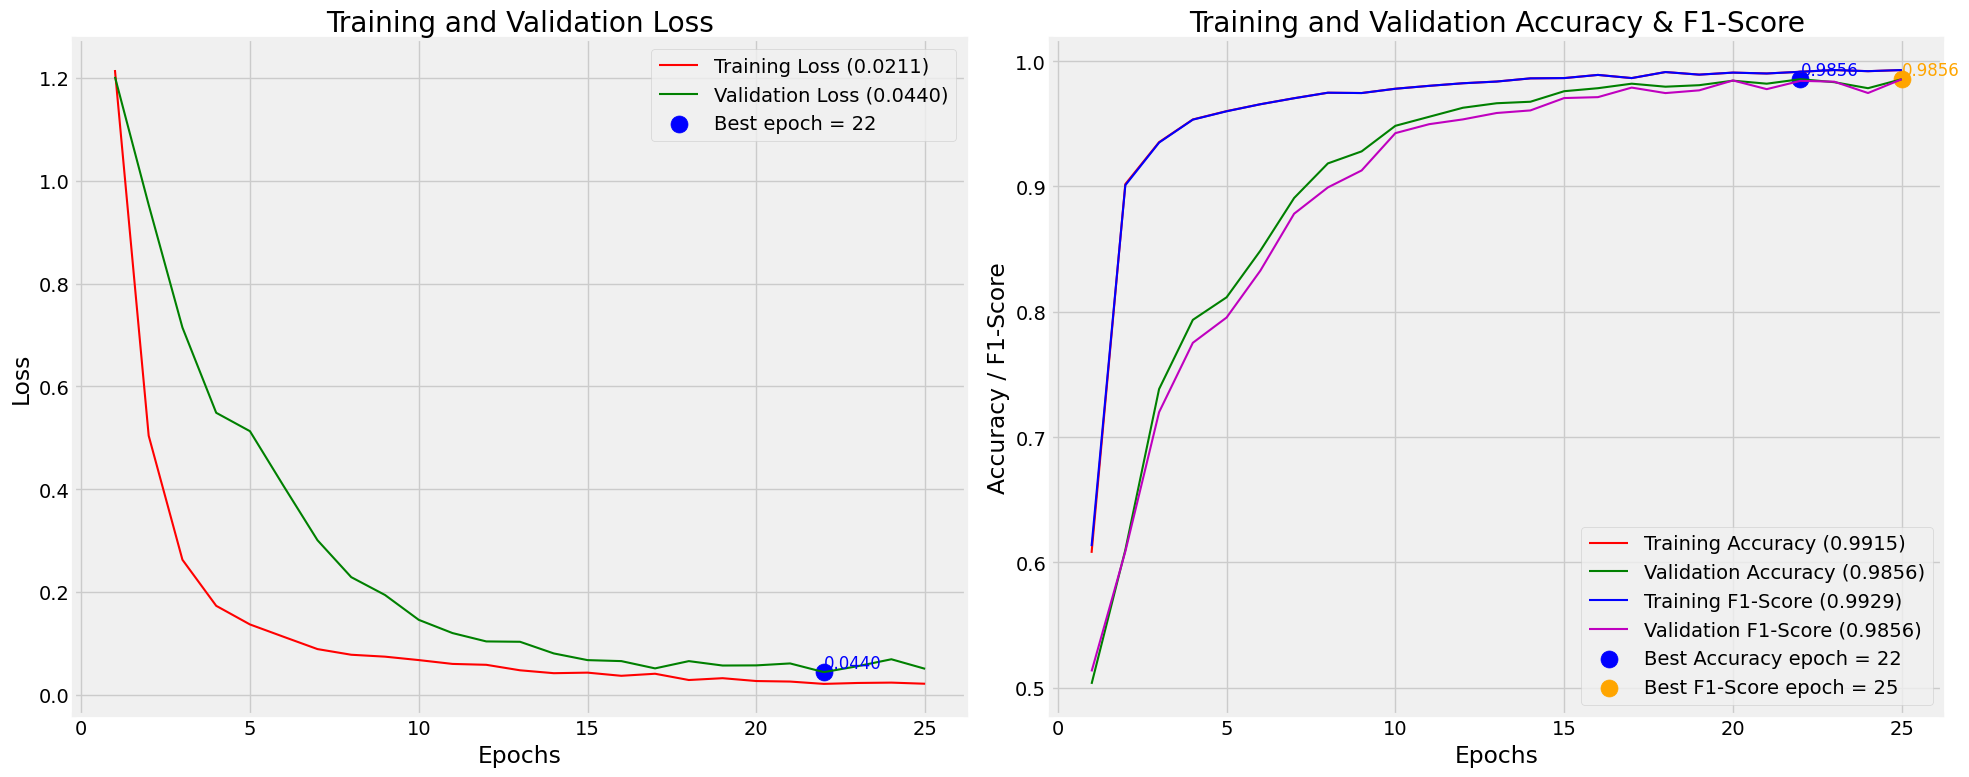

In [21]:
# Define needed variables
history_dict = history.history

# Hitung rata-rata F1-score
tr_f1 = np.array([np.mean(f1) for f1 in history_dict['f1_score']])
val_f1 = np.array([np.mean(f1) for f1 in history_dict['val_f1_score']])

# Ambil nilai lainnya
tr_acc = np.array(history_dict['accuracy'])
tr_loss = np.array(history_dict['loss'])
val_acc = np.array(history_dict['val_accuracy'])
val_loss = np.array(history_dict['val_loss'])

# Temukan indeks dan nilai terbaik
index_loss, val_lowest = np.argmin(val_loss), np.min(val_loss)
index_acc, acc_highest = np.argmax(val_acc), np.max(val_acc)
index_f1, f1_highest = np.argmax(val_f1), np.max(val_f1)
epochs = np.arange(1, len(tr_acc) + 1)

# Plot training history
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label=f'Training Loss ({tr_loss[index_loss]:.4f})', linewidth=1.5)
plt.plot(epochs, val_loss, 'g', label=f'Validation Loss ({val_lowest:.4f})', linewidth=1.5)
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=f'Best epoch = {index_loss + 1}')
plt.text(index_loss + 1, val_lowest, f"{val_lowest:.4f}", fontsize=12, ha='left', va='bottom', color='blue')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gabungkan Akurasi dan F1-Score dalam satu plot
plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label=f'Training Accuracy ({tr_acc[index_acc]:.4f})', linewidth=1.5)
plt.plot(epochs, val_acc, 'g', label=f'Validation Accuracy ({acc_highest:.4f})', linewidth=1.5)
plt.plot(epochs, tr_f1, 'b', label=f'Training F1-Score ({tr_f1[index_f1]:.4f})', linewidth=1.5)
plt.plot(epochs, val_f1, 'm', label=f'Validation F1-Score ({f1_highest:.4f})', linewidth=1.5)
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=f'Best Accuracy epoch = {index_acc + 1}')
plt.scatter(index_f1 + 1, f1_highest, s=150, c='orange', label=f'Best F1-Score epoch = {index_f1 + 1}')
plt.text(index_acc + 1, acc_highest, f"{acc_highest:.4f}", fontsize=12, ha='left', va='bottom', color='blue')
plt.text(index_f1 + 1, f1_highest, f"{f1_highest:.4f}", fontsize=12, ha='left', va='bottom', color='orange')
plt.title('Training and Validation Accuracy & F1-Score')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / F1-Score')
plt.legend()

plt.tight_layout()
plt.show()

## 4. Evaluasi Model  

Setelah training selesai, model dievaluasi menggunakan **Test Set** untuk mengukur performanya pada data yang belum pernah dilihat sebelumnya.

### 4.1 Proses Evaluasi
Evaluasi dilakukan dengan menguji model pada dataset **Test Set** yang berisi gambar yang tidak termasuk dalam dataset training maupun validasi. Model akan memprediksi kelas dari setiap gambar dalam test set, dan hasilnya dibandingkan dengan label sebenarnya.

### 4.2 Analisis Confusion Matrix
Hasil evaluasi divisualisasikan menggunakan **Confusion Matrix**, yang menunjukkan jumlah prediksi benar dan salah untuk setiap kelas. Confusion matrix ini memberikan gambaran detail tentang bagaimana model melakukan klasifikasi dan kategori mana yang paling sering keliru diklasifikasikan.

Dari confusion matrix yang didapatkan, terlihat bahwa model memiliki akurasi tinggi dalam mengklasifikasikan semua kategori, dengan kesalahan klasifikasi yang sangat minim.

### 4.3 Evaluasi Metrik
Untuk menilai performa model secara lebih rinci, digunakan metrik berikut:
- **Precision**: Seberapa banyak prediksi yang benar dibandingkan total prediksi positif.
- **Recall**: Seberapa banyak prediksi benar dibandingkan total data yang seharusnya diprediksi benar.
- **F1-Score**: Rata-rata harmonis antara precision dan recall.
- **Akurasi**: Seberapa banyak prediksi yang benar dibandingkan total data.

Hasil evaluasi model berdasarkan metrik tersebut adalah sebagai berikut:

| Label                | Precision | Recall  | F1-Score | Support |
|----------------------|-----------|---------|----------|---------|
| Background          | 1.0000    | 1.0000  | 1.0000   | 229     |
| Grape Black Rot     | 0.9913    | 0.9703  | 0.9807   | 236     |
| Grape Esca         | 0.9821    | 0.9928  | 0.9874   | 277     |
| Grape Leaf Blight   | 0.9907    | 0.9907  | 0.9907   | 216     |
| Grape Healthy      | 0.9770    | 1.0000  | 0.9884   | 85      |
| **Accuracy**        | **-**     | **-**   | **0.9895** | **1043** |

Hasil evaluasi menunjukkan bahwa model memiliki performa yang sangat baik dengan akurasi **98.95%** dan nilai F1-Score yang tinggi untuk semua kelas.

### 4.4 Penyimpanan Model
Setelah evaluasi selesai, model disimpan agar dapat digunakan kembali tanpa perlu dilatih ulang:

```python
model.save('pre_trained_model/MobileNetV3_GrapePlantVillage.h5')
model.save('pre_trained_model/MobileNetV3_GrapePlantVillage.keras')
```

Dengan demikian, model siap digunakan untuk mengklasifikasikan gambar baru secara otomatis.

<hr>
<hr>

In [22]:
# Prediksi pada Test Set
test_preds = model.predict(test_gen)
y_pred = np.argmax(test_preds, axis=1)
y_true = test_gen.classes

33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step


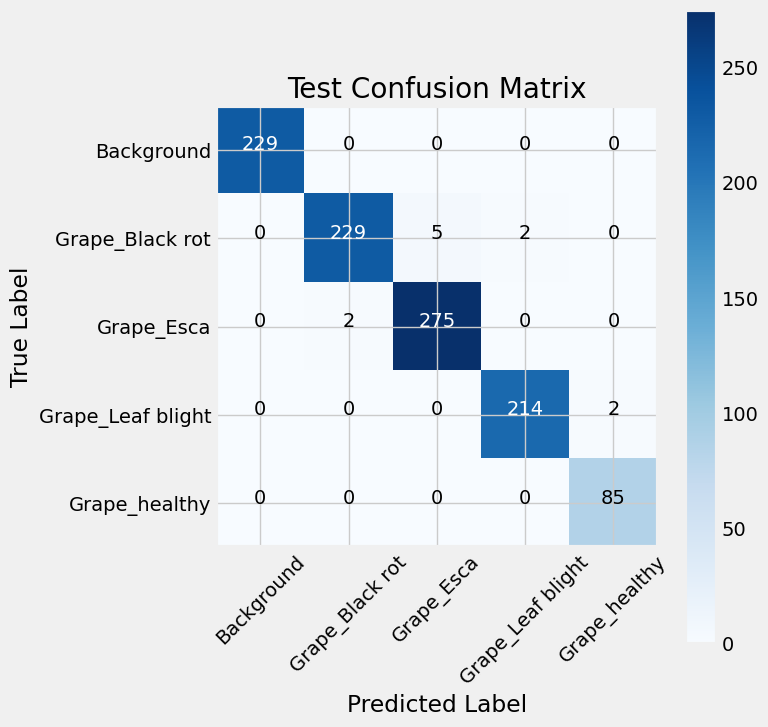

In [23]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Test Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Plot Confusion Matrix
plot_confusion_matrix(y_true, y_pred, list(test_gen.class_indices.keys()))

In [24]:
print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys()), digits=4))

                   precision    recall  f1-score   support

       Background     1.0000    1.0000    1.0000       229
  Grape_Black rot     0.9913    0.9703    0.9807       236
       Grape_Esca     0.9821    0.9928    0.9874       277
Grape_Leaf blight     0.9907    0.9907    0.9907       216
    Grape_healthy     0.9770    1.0000    0.9884        85

         accuracy                         0.9895      1043
        macro avg     0.9882    0.9908    0.9895      1043
     weighted avg     0.9895    0.9895    0.9894      1043



In [25]:
model.save('pre_trained_model/MobileNetV3_GrapePlantVillage.h5')
model.save('pre_trained_model/MobileNetV3_GrapePlantVillage.keras')